# Word to Vector

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [38]:
# NLTK
import nltk
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('names')


# Tokeenization
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.corpus import wordnet
from nltk import pos_tag, pos_tag_sents
from nltk.stem import WordNetLemmatizer

# Vectorizer
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Utilities
from collections import OrderedDict
import pickle
from tqdm import tqdm
import operator 

# Plotting
from matplotlib import pyplot as plt

# Classifier
from sklearn.naive_bayes import MultinomialNB

# Word Embedding
from gensim.models.keyedvectors import KeyedVectors

# Spell check
from spellchecker import SpellChecker

import re
import gc

# Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from gensim.matutils import unitvec

import logging
import normalise

from keras.preprocessing.text import Tokenizer, text_to_word_sequence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [4]:
tqdm.pandas("Progress")

## Load and resampling dataset

In [3]:
training_dataset = pd.read_csv("../input/train.csv")
testing_dataset = pd.read_csv("../input/test.csv")

In [29]:
training_dataset_tiny = training_dataset.sample(frac=0.01, random_state=42)
training_dataset_small = training_dataset.sample(frac=0.1, random_state=42)

## Pretrained Word Embedding

In [5]:
gc.collect()

7

In [5]:
googleModel = KeyedVectors.load_word2vec_format("d:/derekhsu/Documents/Study/COMP6237 Data Mining/embeddings/GoogleNews-vectors-negative300.bin", binary=True)
googleModel.init_sims()

## Text preprocessing

In [31]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [32]:
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [33]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [34]:
def clean_numbers(x):
    x = re.sub('[0-9]{6,}', '######', x)
    x = re.sub('[0-9]{5}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}',"##",x)    
    return x

In [35]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium',
                'behaviour': 'behavior',
                'wasnt': 'was not',
                'vapour': 'vapor',
                'humour': 'humor',
                'organise': 'organize'
                }
mispellings, mispellings_re = _get_mispell(mispell_dict)

In [36]:
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [51]:
stopwords_en = set(stopwords.words('english'))
stopwords_en_withpunct = stopwords_en.union(set(punctuation))
stopwords = stopwords_en_withpunct

### Use tiny dataset first

In [40]:
question_text = training_dataset_small["question_text"].progress_apply(lambda x: clean_text(x))
question_text = question_text.progress_apply(lambda x: clean_numbers(x))
question_text = question_text.progress_apply(lambda x: replace_typical_misspell(x))
to_remove = stopwords_list
sentences = question_text.progress_apply(lambda x: text_to_word_sequence(x))
sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)
oov = check_coverage(vocab,googleModel)


100%|█████████████████████████████████████████████████████████████████████████| 58386/58386 [00:04<00:00, 12912.80it/s]

Found embeddings for 65.38% of vocab
Found embeddings for  95.50% of all text


## Build feature vectors

In [15]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in tqdm(text_list, disable=('verbose')) ])

### TF-IDF

In [7]:
stopwords_en = set(stopwords.words('english'))
stopwords_en_withpunct = stopwords_en.union(set(punctuation))
#stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
#stopwords_combined = set.union(set(stopwords_json['en']), stopwords_en_withpunct)
stopwords_list = stopwords_en_withpunct

In [8]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(text_to_word_sequence(text))]

In [58]:

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    
    tokens =  [word for word in lemmatize_sent(text) 
            if word not in stopwords
            and not word.isdigit()]
    try: 
        tokens = normalise.normalise(text=tokens, user_abbrevs=custom_dictionary, verbose=False)
    except:
        result = []
        for text in tokens:
            try:
                result.append(normalise.normalise(texts, verbose=False))
            except:
                result.append(text)
        tokens = result
    tokens = [word for word in tokens
          if word not in stopwords]
    return tokens;

In [10]:
class CustomVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stop_words = self.get_stop_words()
    
        def analyser(doc):
            if (self.lowercase == True):
                doc = doc.lower()
            tokens = preprocess_text(doc)
            
            return(self._word_ngrams(tokens, stop_words))
        return (analyser)

In [26]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 300

    def fit(self, X, y):
        tfidf = CustomVectorizer(encoding='utf-8', decode_error='strict', strip_accents = None)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

In [42]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 300
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [25]:
googleModel.vectors.shape

(3000000, 300)

### Word2VectorOnly

In [45]:
word_tokens = question_text.progress_apply(lambda x: text_to_word_sequence(x))


100%|███████████████████████████████████████████████████████████████████████| 130612/130612 [00:01<00:00, 94081.18it/s]

In [35]:
word_average_vectors = word_averaging_list(googleModel, word_tokens)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [36]:
df_word_vectors = pd.DataFrame(word_average_vectors)

In [40]:
df_word_vectors['target'] = training_dataset_small['target'].values

### Word2Vector + TF-IDF

In [54]:
custom_dictionary = { "won't": 'will not'}

In [53]:
normalise.normalise("Ryan's book", user_abbrevs=custom_dictionary, verbose=False)

NameError: name 'custom_dictionary' is not defined

In [27]:
tfidfEmbeddingVectors = TfidfEmbeddingVectorizer(googleModel)

In [59]:
tfidfEmbeddingVectors.fit(question_text, None)

NameError: name 'defaultdict' is not defined

## Visualize by SVD

In [51]:
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
tfidf_vectors_small_preprocessing_svd = svd.fit_transform(X=df_word_vectors[df_word_vectors.columns.delete(-1)])

In [52]:
df_embedding_vectors_small_preprocessing_svd = pd.DataFrame(tfidf_vectors_small_preprocessing_svd)

In [54]:
df_embedding_vectors_small_preprocessing_svd['target'] = training_dataset_small['target']

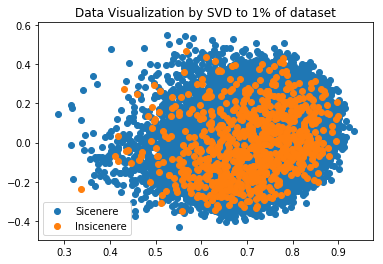

In [56]:
plt.scatter(x=df_embedding_vectors_small_preprocessing_svd[df_embedding_vectors_small_preprocessing_svd['target'] == 0][0], y=df_embedding_vectors_small_preprocessing_svd[df_embedding_vectors_small_preprocessing_svd['target'] == 0][1])
plt.scatter(x=df_embedding_vectors_small_preprocessing_svd[df_embedding_vectors_small_preprocessing_svd['target'] == 1][0], y=df_embedding_vectors_small_preprocessing_svd[df_embedding_vectors_small_preprocessing_svd['target'] == 1][1])
plt.legend(['Sicenere', 'Insicenere'])
plt.title("Data Visualization by SVD to 1% of dataset")
plt.savefig("Data_Visualization_by_SVD_to_1%_of_dataset")

## Visualize by Kernal PCA

Because of the size of data causing memory limit, Kernal PCA is not able to do decomposition. Hence, the small set of original dataset is resampled again into a smaller dataset.

In [59]:
from sklearn.decomposition import PCA, KernelPCA

In [74]:
df_word_vectors_tiny = df_word_vectors.sample(frac=0.01, random_state=42)

In [75]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
embedding_tiny_preprocessing_kpca = kpca.fit_transform(df_word_vectors_tiny[df_word_vectors_tiny.columns.delete(-1)])

array([[-1.54582022e-02, -9.22204632e-04, -1.42033906e-03, ...,
        -4.23369186e-04, -4.51250657e-04,  2.37849299e-04],
       [-6.87837437e-03, -4.44736229e-03,  7.09201568e-03, ...,
         3.08314423e-04, -1.23969863e-03, -5.42019795e-04],
       [-1.35939096e-02, -3.95041795e-03, -2.07950252e-02, ...,
         1.93303534e-04,  2.16523902e-04,  2.35890808e-04],
       ...,
       [-1.67386581e-02,  2.78461005e-03,  5.02977019e-03, ...,
         2.12966511e-04,  4.34346275e-04,  7.32389397e-05],
       [-2.12452398e-02,  3.15452160e-03,  1.01232535e-02, ...,
        -2.59357437e-05, -3.53094312e-05,  2.60376018e-05],
       [-2.02364870e-02,  2.93204701e-03,  7.70334299e-03, ...,
         4.39743419e-05, -5.93837566e-05,  1.02235166e-04]])

Text(0.5,1,'Data Visualization by KernalPCA(RBF) to 1% of dataset')

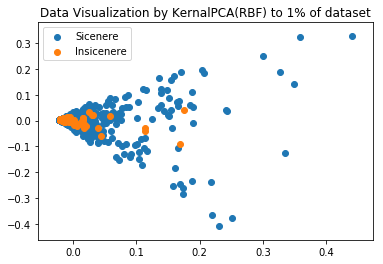

In [84]:
plt.scatter(x=embedding_tiny_preprocessing_kpca[df_word_vectors_tiny['target'] == 0, 0], y=embedding_tiny_preprocessing_kpca[df_word_vectors_tiny['target'] == 0, 1])
plt.scatter(x=embedding_tiny_preprocessing_kpca[df_word_vectors_tiny['target'] == 1, 0], y=embedding_tiny_preprocessing_kpca[df_word_vectors_tiny['target'] == 1, 1])
plt.legend(['Sicenere', 'Insicenere'])
plt.title("Data Visualization by KernalPCA(RBF) to 1% of dataset")

## GaussianNB

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df_word_vectors[df_word_vectors.columns.delete(-1)], df_word_vectors[df_word_vectors.columns[-1]], test_size=0.2, random_state=42)

In [96]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [98]:
print("Accuracy score: %f"%accuracy_score(y_true=y_test, y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=y_test, y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.855376
Recall score: 0.799613
F1 score: 0.396486


## Random Forest

In [111]:
randomForestClassifier = RandomForestClassifier(n_estimators=50, 
                       max_depth=150,
                       min_samples_leaf=5,
                       max_features="auto",
                       n_jobs=-1)

randomForestClassifier.fit(X_train, y_train)
y_pred = randomForestClassifier.predict(X_test)


In [112]:
print("Accuracy score: %f"%accuracy_score(y_true=y_test, y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=y_test, y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.944034
Recall score: 0.092784
F1 score: 0.164571


## LogisticRegression

In [123]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [124]:
lrClf = LogisticRegressionCV(random_state=42, solver='newton-cg',
                   multi_class='ovr').fit(X_train, y_train)

In [121]:
y_pred = lrClf.predict(X_test)

In [122]:
print("Accuracy score: %f"%accuracy_score(y_true=y_test, y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=y_test, y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.950159
Recall score: 0.347938
F1 score: 0.453401


## Use full dataset

In [14]:
question_text = training_dataset["question_text"].progress_apply(lambda x: clean_text(x))
question_text = question_text.progress_apply(lambda x: clean_numbers(x))
question_text = question_text.progress_apply(lambda x: replace_typical_misspell(x))
to_remove = stopwords_list
sentences = question_text.progress_apply(lambda x: text_to_word_sequence(x))
sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)
oov = check_coverage(vocab,googleModel)

100%|██████████████████████████████████████████████████████████████████████| 196559/196559 [00:00<00:00, 357015.41it/s]


Found embeddings for 38.97% of vocab
Found embeddings for  95.51% of all text


In [16]:
word_tokens = question_text.progress_apply(lambda x: text_to_word_sequence(x))
word_average_vectors = word_averaging_list(googleModel, word_tokens)
df_word_vectors = pd.DataFrame(word_average_vectors)
df_word_vectors['target'] = training_dataset['target'].values

100%|█████████████████████████████████████████████████████████████████████| 1306122/1306122 [00:13<00:00, 97716.57it/s]
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


ValueError: Length of values does not match length of index

### Visualize by SVD

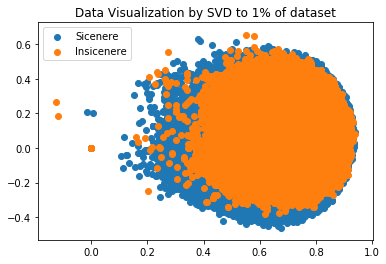

In [20]:
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
embedding_vectors_preprocessing_svd = svd.fit_transform(X=df_word_vectors[df_word_vectors.columns.delete(-1)])

df_embedding_vectors_preprocessing_svd = pd.DataFrame(embedding_vectors_preprocessing_svd)
df_embedding_vectors_preprocessing_svd['target'] = training_dataset['target']

plt.scatter(x=df_embedding_vectors_preprocessing_svd[df_embedding_vectors_preprocessing_svd['target'] == 0][0], y=df_embedding_vectors_preprocessing_svd[df_embedding_vectors_preprocessing_svd['target'] == 0][1])
plt.scatter(x=df_embedding_vectors_preprocessing_svd[df_embedding_vectors_preprocessing_svd['target'] == 1][0], y=df_embedding_vectors_preprocessing_svd[df_embedding_vectors_preprocessing_svd['target'] == 1][1])
plt.legend(['Sicenere', 'Insicenere'])
plt.title("Data Visualization by SVD to 1% of dataset")
plt.savefig("Data_Visualization_by_SVD_to_1%_of_dataset_full.eps")

### Machine Learning

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_word_vectors[df_word_vectors.columns.delete(-1)], df_word_vectors[df_word_vectors.columns[-1]], test_size=0.2, random_state=42)

#### Gaussian Naive Bayes

In [22]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [23]:
print("Accuracy score: %f"%accuracy_score(y_true=y_test, y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=y_test, y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.850619
Recall score: 0.804175
F1 score: 0.395233


#### Random Forest

In [24]:
randomForestClassifier = RandomForestClassifier(n_estimators=50, 
                       max_depth=150,
                       min_samples_leaf=5,
                       max_features="auto",
                       n_jobs=-1)

randomForestClassifier.fit(X_train, y_train)
y_pred = randomForestClassifier.predict(X_test)


In [25]:
print("Accuracy score: %f"%accuracy_score(y_true=y_test, y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=y_test, y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.945074
Recall score: 0.139190
F1 score: 0.235263


## Play ground

In [ ]:
training_dataset_tiny["question_text"] = training_dataset_tiny["question_text"].progress_apply(lambda x: clean_text(x))
training_dataset_tiny["question_text"] = training_dataset_tiny["question_text"].progress_apply(lambda x: clean_numbers(x))
training_dataset_tiny["question_text"] = training_dataset_tiny["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
to_remove = ['a','to','of','and']
sentences = training_dataset_tiny["question_text"].progress_apply(lambda x: text_to_word_sequence(x))
sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)

In [ ]:
for text in training_dataset_tiny["question_text"][:100]:
    print(text)
    print(clean_text(text))

In [ ]:
for text in training_dataset_tiny["question_text"][:100]:
    print(text)
    print(clean_numbers(clean_text(text)))

In [ ]:
for text in training_dataset_tiny["question_text"][:100]:
    print(text)
    print(replace_typical_misspell(clean_numbers(clean_text(text))))

In [50]:
df_word_vectors[df_word_vectors.columns.delete(-1)]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.024183,0.028250,0.024963,0.041708,-0.029250,0.049208,0.074138,-0.052269,0.050974,0.007057,...,-0.185519,0.051221,-0.069886,0.000332,-0.067647,0.021380,0.081306,-0.030925,0.030900,0.046825
1,-0.034344,0.053045,0.030247,0.096677,-0.004025,0.018668,-0.012789,-0.146380,0.037113,0.063946,...,-0.047061,0.019994,-0.093446,0.022300,-0.023442,0.025390,-0.099160,-0.022558,0.008296,0.018714
2,0.002254,0.010782,0.053419,0.140935,-0.046168,0.008718,0.028950,-0.035454,0.068349,-0.014136,...,-0.086932,0.036622,-0.156048,-0.091345,-0.058796,-0.000896,0.021326,-0.032114,0.021848,0.008779
3,0.017690,-0.056553,-0.038622,0.055165,-0.059770,0.069895,0.040960,-0.017272,0.089680,0.035920,...,0.022441,-0.008658,-0.076379,-0.051519,0.085898,-0.047958,-0.067499,-0.032549,-0.031839,0.034919
4,0.043310,-0.006074,0.054177,0.072245,-0.017348,0.073682,0.006177,-0.112562,0.114786,0.039063,...,-0.121447,0.088739,-0.046694,0.015062,0.028208,0.001035,0.040646,-0.029562,-0.047196,-0.039211
5,0.069406,0.027082,0.084482,0.117868,-0.033701,0.007598,0.073815,-0.060962,0.075027,0.028542,...,-0.096244,-0.021143,-0.106266,-0.009276,0.015903,-0.019334,0.019430,0.029008,0.020232,-0.060467
6,0.064387,0.081630,0.047374,-0.010816,-0.017473,0.003814,0.037642,-0.104133,0.028306,0.061247,...,-0.123086,-0.100188,-0.071101,0.031396,-0.067115,-0.032719,-0.027204,0.021928,0.070806,0.037873
7,0.038262,-0.015976,0.040609,0.162436,-0.074827,-0.034177,-0.016189,-0.096617,0.014014,0.029714,...,-0.098806,0.038383,-0.130458,0.059435,-0.050048,0.035073,-0.036464,-0.003131,-0.011088,-0.040043
8,0.031778,0.015153,0.054683,0.069304,-0.038862,-0.064710,0.050428,-0.117786,0.093341,-0.018786,...,-0.075189,0.015063,-0.075110,-0.008918,-0.052284,-0.038262,0.024286,-0.004866,0.077272,-0.042642
9,0.059357,0.027830,0.065709,0.100903,-0.086394,0.072705,0.074048,-0.048714,-0.016959,-0.022569,...,-0.130727,0.069289,-0.074214,-0.043820,-0.098496,-0.031143,0.109109,-0.046709,-0.009768,0.021104
